In [1]:
import os
import numpy as np
from PIL import Image
from torchvision import transforms
import torchvision.datasets as datasets
import cv2
from matplotlib import pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torchvision import models
from transformers import ViTForImageClassification, ViTImageProcessor 
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_scheduler
import torch.nn.functional as F

2024-05-09 17:32:18.415629: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 17:32:18.415719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 17:32:18.528145: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_dir = r'/kaggle/input/brain-tumor-classification-mri/Training'
test_dir = r'/kaggle/input/brain-tumor-classification-mri/Testing'

In [3]:
class CustomDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        image = Image.open(path).convert('RGB')  # RGB
        image = np.array(image)


        # Apply transformations
        image = Image.fromarray(image)
        if self.transform is not None:
            image = self.transform(image)
        
        return image, target

In [4]:
def calc_mean_std(folder_path):
    means, stds = [], []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                image_path = os.path.join(root, file)
                image = Image.open(image_path)
                np_image = np.array(image) / 255.0  # Normalize to [0, 1]
                means.append(np.mean(np_image, axis=(0, 1)))  
                stds.append(np.std(np_image, axis=(0, 1)))  
    mean = np.mean(means, axis=0)
    std = np.mean(stds, axis=0)
    return mean, std

In [5]:
folder_path = train_dir
mean, std = calc_mean_std(folder_path)
print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

Mean: [0.17937622 0.17937622 0.17937622]
Standard Deviation: [0.17518265 0.17518265 0.17518265]


In [6]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', restore_best_weights=False):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.restore_best_weights = restore_best_weights
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.best_weights = None

    def __call__(self, model, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights and self.best_weights is not None:
                    model.load_state_dict(self.best_weights)
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} to {val_loss:.6f}).  Saving model to {self.path}')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        if self.restore_best_weights:
            self.best_weights = model.state_dict()

In [7]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

batch_size = 32

transform1 = transforms.Compose([
    transforms.Resize((384,384)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.17937622, 0.17937622, 0.17937622],
                         std=[0.17518265, 0.17518265, 0.17518265])

])

transform2 = transforms.Compose([
    transforms.Resize((384,384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.17937622, 0.17937622, 0.17937622],
                         std=[0.17518265, 0.17518265, 0.17518265])
])
train_dataset = CustomDataset(root=train_dir, transform=transform1)
test_dataset = CustomDataset(root=test_dir, transform=transform2)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the feature extractor and model from Hugging Face Transformers
model = ViTForImageClassification.from_pretrained('google/vit-base-patch32-384')

num_classes = 4
model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)

model.to(device)

# Loss Function
criterion = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay = 1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2, threshold=0.000075, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
early_stopping = EarlyStopping(patience=20, restore_best_weights=True, verbose=1)


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Epoch [1/30]: 100%|██████████| 90/90 [01:19<00:00,  1.13it/s, loss=0.14] 


Accuracy on the test set: 68.78%
Epoch 1, Validation Loss: 1.0709
Validation loss decreased (inf to 1.070940).  Saving model to checkpoint.pt


Epoch [2/30]: 100%|██████████| 90/90 [01:19<00:00,  1.13it/s, loss=0.148] 


Accuracy on the test set: 62.18%
Epoch 2, Validation Loss: 1.3541
EarlyStopping counter: 1 out of 20


Epoch [3/30]: 100%|██████████| 90/90 [01:18<00:00,  1.14it/s, loss=0.151] 


Accuracy on the test set: 75.13%
Epoch 3, Validation Loss: 0.9310
Validation loss decreased (1.070940 to 0.931031).  Saving model to checkpoint.pt


Epoch [4/30]: 100%|██████████| 90/90 [01:19<00:00,  1.13it/s, loss=0.15]   


Accuracy on the test set: 78.17%
Epoch 4, Validation Loss: 0.8732
Validation loss decreased (0.931031 to 0.873158).  Saving model to checkpoint.pt


Epoch [5/30]: 100%|██████████| 90/90 [01:20<00:00,  1.12it/s, loss=0.105]  


Accuracy on the test set: 76.65%
Epoch 5, Validation Loss: 0.8998
EarlyStopping counter: 1 out of 20


Epoch [6/30]: 100%|██████████| 90/90 [01:19<00:00,  1.13it/s, loss=0.00885]


Accuracy on the test set: 81.73%
Epoch 6, Validation Loss: 0.9435
EarlyStopping counter: 2 out of 20


Epoch [7/30]: 100%|██████████| 90/90 [01:19<00:00,  1.13it/s, loss=0.00555]


Accuracy on the test set: 80.71%
Epoch 7, Validation Loss: 0.8341
Validation loss decreased (0.873158 to 0.834121).  Saving model to checkpoint.pt


Epoch [8/30]: 100%|██████████| 90/90 [01:18<00:00,  1.15it/s, loss=0.00714] 


Accuracy on the test set: 80.46%
Epoch 8, Validation Loss: 1.0290
EarlyStopping counter: 1 out of 20


Epoch [9/30]: 100%|██████████| 90/90 [01:18<00:00,  1.14it/s, loss=0.00376]


Accuracy on the test set: 82.99%
Epoch 9, Validation Loss: 0.7700
Validation loss decreased (0.834121 to 0.770009).  Saving model to checkpoint.pt


Epoch [10/30]: 100%|██████████| 90/90 [01:18<00:00,  1.15it/s, loss=0.0122] 


Accuracy on the test set: 82.74%
Epoch 10, Validation Loss: 0.6805
Validation loss decreased (0.770009 to 0.680519).  Saving model to checkpoint.pt


Epoch [11/30]: 100%|██████████| 90/90 [01:19<00:00,  1.13it/s, loss=0.0601] 


Accuracy on the test set: 79.95%
Epoch 11, Validation Loss: 1.1103
EarlyStopping counter: 1 out of 20


Epoch [12/30]: 100%|██████████| 90/90 [01:19<00:00,  1.13it/s, loss=0.00765]


Accuracy on the test set: 81.73%
Epoch 12, Validation Loss: 1.1030
EarlyStopping counter: 2 out of 20


Epoch [13/30]: 100%|██████████| 90/90 [01:20<00:00,  1.12it/s, loss=0.000794]


Accuracy on the test set: 77.92%
Epoch 13, Validation Loss: 1.3275
EarlyStopping counter: 3 out of 20
Epoch 00013: reducing learning rate of group 0 to 1.5000e-05.


Epoch [14/30]: 100%|██████████| 90/90 [01:20<00:00,  1.12it/s, loss=0.000737]


Accuracy on the test set: 79.95%
Epoch 14, Validation Loss: 1.1580
EarlyStopping counter: 4 out of 20


Epoch [15/30]: 100%|██████████| 90/90 [01:20<00:00,  1.12it/s, loss=0.00324] 


Accuracy on the test set: 80.20%
Epoch 15, Validation Loss: 1.1268
EarlyStopping counter: 5 out of 20


Epoch [16/30]: 100%|██████████| 90/90 [01:19<00:00,  1.13it/s, loss=0.00323] 


Accuracy on the test set: 80.96%
Epoch 16, Validation Loss: 1.0596
EarlyStopping counter: 6 out of 20
Epoch 00016: reducing learning rate of group 0 to 4.5000e-06.


Epoch [17/30]: 100%|██████████| 90/90 [01:18<00:00,  1.14it/s, loss=0.000662]


Accuracy on the test set: 80.20%
Epoch 17, Validation Loss: 1.1104
EarlyStopping counter: 7 out of 20


Epoch [18/30]: 100%|██████████| 90/90 [01:18<00:00,  1.14it/s, loss=0.00235] 


Accuracy on the test set: 80.20%
Epoch 18, Validation Loss: 1.1415
EarlyStopping counter: 8 out of 20


Epoch [19/30]: 100%|██████████| 90/90 [01:19<00:00,  1.13it/s, loss=0.000235]


Accuracy on the test set: 79.95%
Epoch 19, Validation Loss: 1.1785
EarlyStopping counter: 9 out of 20
Epoch 00019: reducing learning rate of group 0 to 1.3500e-06.


Epoch [20/30]: 100%|██████████| 90/90 [01:19<00:00,  1.14it/s, loss=0.00223] 


Accuracy on the test set: 79.95%
Epoch 20, Validation Loss: 1.1809
EarlyStopping counter: 10 out of 20


Epoch [21/30]: 100%|██████████| 90/90 [01:19<00:00,  1.13it/s, loss=0.000393]


Accuracy on the test set: 79.95%
Epoch 21, Validation Loss: 1.1606
EarlyStopping counter: 11 out of 20


Epoch [22/30]: 100%|██████████| 90/90 [01:19<00:00,  1.13it/s, loss=0.000795]


Accuracy on the test set: 79.95%
Epoch 22, Validation Loss: 1.1913
EarlyStopping counter: 12 out of 20
Epoch 00022: reducing learning rate of group 0 to 4.0500e-07.


Epoch [23/30]: 100%|██████████| 90/90 [01:19<00:00,  1.13it/s, loss=0.000359]


Accuracy on the test set: 79.95%
Epoch 23, Validation Loss: 1.1947
EarlyStopping counter: 13 out of 20


Epoch [24/30]: 100%|██████████| 90/90 [01:19<00:00,  1.13it/s, loss=0.00418] 


Accuracy on the test set: 79.95%
Epoch 24, Validation Loss: 1.1961
EarlyStopping counter: 14 out of 20


Epoch [25/30]: 100%|██████████| 90/90 [01:20<00:00,  1.12it/s, loss=0.000971]


Accuracy on the test set: 79.95%
Epoch 25, Validation Loss: 1.1985
EarlyStopping counter: 15 out of 20
Epoch 00025: reducing learning rate of group 0 to 1.2150e-07.


Epoch [26/30]: 100%|██████████| 90/90 [01:18<00:00,  1.14it/s, loss=0.00105] 


Accuracy on the test set: 79.95%
Epoch 26, Validation Loss: 1.1959
EarlyStopping counter: 16 out of 20


Epoch [27/30]: 100%|██████████| 90/90 [01:18<00:00,  1.14it/s, loss=0.000344]


Accuracy on the test set: 79.95%
Epoch 27, Validation Loss: 1.1969
EarlyStopping counter: 17 out of 20


Epoch [28/30]: 100%|██████████| 90/90 [01:19<00:00,  1.13it/s, loss=0.00153] 


Accuracy on the test set: 79.95%
Epoch 28, Validation Loss: 1.1959
EarlyStopping counter: 18 out of 20
Epoch 00028: reducing learning rate of group 0 to 3.6450e-08.


Epoch [29/30]: 100%|██████████| 90/90 [01:20<00:00,  1.12it/s, loss=0.00147] 


Accuracy on the test set: 79.95%
Epoch 29, Validation Loss: 1.1945
EarlyStopping counter: 19 out of 20


Epoch [30/30]: 100%|██████████| 90/90 [01:20<00:00,  1.11it/s, loss=0.000973]


Accuracy on the test set: 79.95%
Epoch 30, Validation Loss: 1.1937
EarlyStopping counter: 20 out of 20
Early stopping triggered


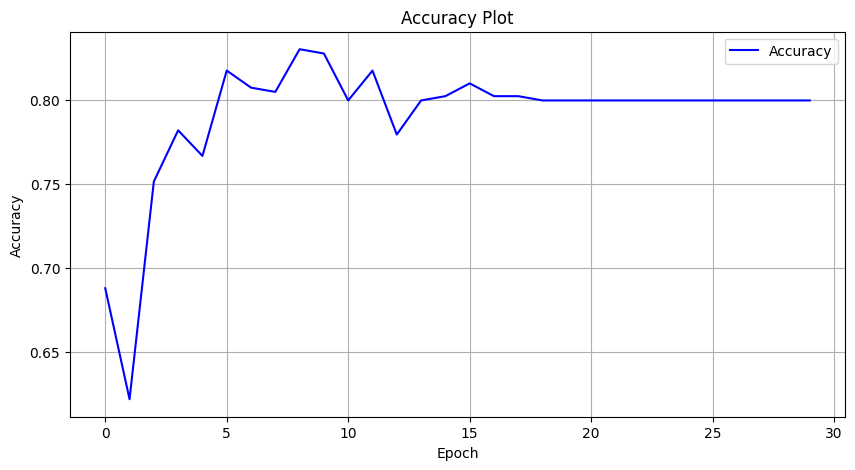

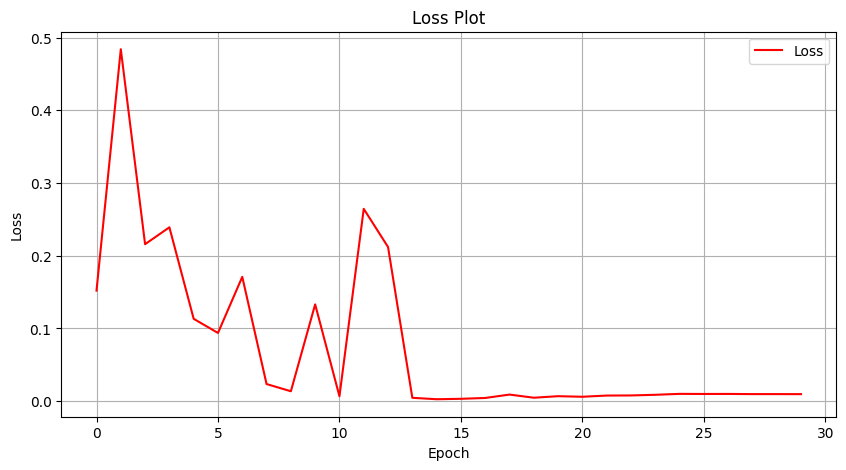

In [8]:
from tqdm import tqdm

epochs = 30
losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(epochs):
    model.train()
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        loop.set_description(f'Epoch [{epoch+1}/{epochs}]')
        loop.set_postfix(loss=loss.item())

    # Evaluation phase
    model.eval()
    valid_loss = 0.0
    total, correct = 0, 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs.logits, labels)
            valid_loss += loss.item()

    accuracy = correct / total
    losses.append(loss.item())
    valid_accuracies.append(accuracy)
    print(f'Accuracy on the test set: {100 * accuracy:.2f}%')

    valid_loss /= len(test_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {valid_loss:.4f}')

    # Early Stopping check
    early_stopping(model, valid_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

    scheduler.step(valid_loss)

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(valid_accuracies, label='Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot')
plt.legend()
plt.grid(True)
plt.show()

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
model.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Assuming model, test_loader, device, and criterion are already defined
model.eval()
valid_loss = 0.0
total, correct = 0, 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        loss = criterion(outputs.logits, labels)
        valid_loss += loss.item()

accuracy = correct / total
losses.append(loss.item())
valid_accuracies.append(accuracy)
print(f'Accuracy on the test set: {100 * accuracy:.2f}%')

# Convert lists to numpy arrays for metric calculation
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate additional metrics
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
f1 = f1_score(all_labels, all_predictions, average='macro')
try:
    roc_auc = roc_auc_score(all_labels, all_predictions, multi_class='ovo')  # Use 'ovo' for multi-class
except ValueError:
    roc_auc = None  # ROC AUC can't be calculated for binary classification without probability scores

# Print the additional metrics
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
if roc_auc:
    print(f'ROC-AUC: {roc_auc:.2f}')

Accuracy on the test set: 82.74%
Precision: 0.87
Recall: 0.82
F1 Score: 0.82


In [11]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [12]:
!pip install graphviz

In [13]:
from graphviz import Digraph

dot = Digraph(comment='The Vision Transformer Architecture')
dot.attr(rankdir='LR') 
# Add nodes with subgraphs for clustering
with dot.subgraph(name='cluster_0') as c:
    c.attr(color='blue')
    c.node_attr['style'] = 'filled'
    c.edges([('input', 'patches'), ('patches', 'embedding')])
    c.attr(label='Input and Patch Embeddings')

with dot.subgraph(name='cluster_1') as c:
    c.attr(color='red')
    c.node_attr['style'] = 'filled'
    c.edges([('embedding', 'self_attention'), ('self_attention', 'dense1'), ('dense1', 'gelu'), ('gelu', 'dense2'), ('dense2', 'dropout'), ('dropout', 'layernorm1'), ('layernorm1', 'self_attention_output')])
    c.attr(label='Encoder Layers (x12)')

dot.edge('self_attention_output', 'layernorm2', label='Repeat x12')
dot.edge('layernorm2', 'classifier', label='Final Layer Norm and Classifier')

# Define node shapes and styles
dot.node('input', 'Input Image')
dot.node('patches', 'Patchify')
dot.node('embedding', 'Patch Embeddings\n+ Position Embedding')
dot.node('self_attention', 'Multi-Head Self-Attention')
dot.node('dense1', 'Dense Layer')
dot.node('gelu', 'GELU Activation')
dot.node('dense2', 'Dense Layer')
dot.node('dropout', 'Dropout')
dot.node('layernorm1', 'LayerNorm')
dot.node('self_attention_output', 'Attention Output')
dot.node('layernorm2', 'LayerNorm')
dot.node('classifier', 'Classifier (4 classes)')

# Save the graph to a PDF file (without trying to open it automatically)
dot.render('vit_architecture1', format='pdf')



'vit_architecture1.pdf'